In [1]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

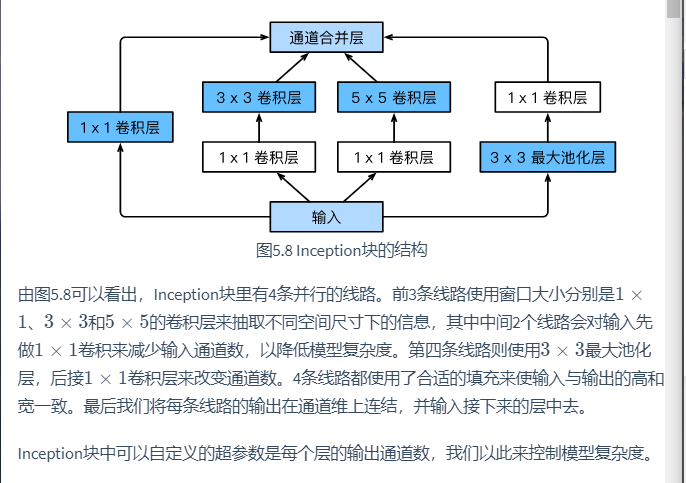

In [2]:
class Inception(nn.Module):
    def __init__(self,in_c,c1,c2,c3,c4):
        super(Inception,self).__init__()
        #路线1
        self.p1_1=nn.Conv2d(in_c,c1,kernel_size=1)
        #线路2
        self.p2_1=nn.Conv2d(in_c,c2[0],kernel_size=1)
        self.p2_2=nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        # 线路3，1 x 1卷积层后接5 x 5卷积层
        self.p3_1 = nn.Conv2d(in_c, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3 x 3最大池化层后接1 x 1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_c, c4, kernel_size=1)
        
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1)  # 在通道维上连结输出

In [3]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


In [4]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


In [7]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


In [8]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [9]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   d2l.GlobalAvgPool2d())

net = nn.Sequential(b1, b2, b3, b4, b5, 
                    d2l.FlattenLayer(), nn.Linear(1024, 10))


In [10]:
net = nn.Sequential(b1, b2, b3, b4, b5, d2l.FlattenLayer(), nn.Linear(1024, 10))
X = torch.rand(1, 1, 96, 96)
for blk in net.children(): 
    X = blk(X)
    print('output shape: ', X.shape)


output shape:  torch.Size([1, 64, 24, 24])
output shape:  torch.Size([1, 192, 12, 12])
output shape:  torch.Size([1, 480, 6, 6])
output shape:  torch.Size([1, 832, 3, 3])
output shape:  torch.Size([1, 1024, 1, 1])
output shape:  torch.Size([1, 1024])
output shape:  torch.Size([1, 10])


In [ ]:
batch_size = 128
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)


training on  cpu
